In [1]:
%matplotlib notebook
from datetime import timedelta
from statistics import mean, median

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import seaborn as sns

from load import (get_big_domain,
                  get_domain_df,
                  get_raw_df,
                  get_tranco_df,
                  get_tranco_rank,
                  get_trimmed_domain,
                  EARLY_TRANCO,
                  LATE_TRANCO)

# Load Data
Load and clean the data from the SBO and Tranco CSVs.

Other cleaning steps we might consider:
- Removing websites associated with the study (e.g., sona-systems)
- Removing very short "passwords"

In [2]:
# SBO Data
df = get_raw_df()
df

,sbo_client_id,document_url_domain_first,document_url_domain_second,document_url_domain_third,sbo_browse_type,length,guesses,timestamp
0,295253,com,discover.com,www.discover.com,pageClick,9,1779.5933333333332,2017-02-25 14:05:24
1,295253,com,discover.com,www.discover.com,pageClick,9,1779.5933333333332,2017-02-25 14:05:24
2,295253,com,discover.com,www.discover.com,formSubmission,9,1779.5933333333332,2017-02-25 14:05:24
3,295253,com,zillow.com,www.zillow.com,pageEnter,9,1779.5933333333332,2017-02-21 23:56:38
4,295253,com,zillow.com,www.zillow.com,pageClick,9,1779.5933333333332,2017-02-21 23:56:38
...,...,...,...,...,...,...,...,...
418703,165955,com,digitalreflectioncenter.com,www.digitalreflectioncenter.com,pageClick,9,580937.86,2019-01-04 19:38:43
418704,165955,com,digitalreflectioncenter.com,www.digitalreflectioncenter.com,formSubmission,9,580937.86,2019-01-04 19:38:43
418705,165955,com,clearvoicesurveys.com,www.clearvoicesurveys.com,form,10,1.20287899825e15,2019-01-04 19:39:45
418706,165955,com,clearvoicesurveys.com,www.clearvoicesurveys.com,pageClick,10,1.20287899825e15,2019-01-04 19:42:50


In [3]:
df["timestamp"].min(), df["timestamp"].max(), df["timestamp"].median()

(Timestamp('2016-12-20 03:05:47'),
 Timestamp('2019-01-23 22:54:58'),
 Timestamp('2017-07-30 23:11:32'))

In [4]:
# Quality check:
# Ensure document_url_domain_third always ends with document_url_domain_second, or is "\N"
def document_url_domain_second(row):
    return (row["document_url_domain_third"].endswith(f".{row['document_url_domain_second']}") or
            row["document_url_domain_third"] == "\\N")
assert len(df.loc[~df.apply(document_url_domain_second, axis=1)]) == 0

In [5]:
# Quality check:
# Nothing in document_url_domain_first should have a ".", making it safe to ignore that column.
# We can't do much with a single domain component.
assert len(df.loc[df["document_url_domain_first"].str.contains(".", na=False, regex=False)]) == 0

In [6]:
# Remove rows that don't have domain information
print(f"Initial number of rows: {len(df)}")
df = df.drop(df[(df["document_url_domain_second"] == "\\N") & (df["document_url_domain_third"] == "\\N")].index)
print(f"Number of rows after removing those without domains: {len(df)}")

Initial number of rows: 418708
Number of rows after removing those without domains: 408603


In [7]:
# We want to find the longest domain names we can. This will allow us to process them
# using tldparse to find the pay-level domains that align with Tranco.
df["big_domain"] = df.apply(get_big_domain, axis=1)
df

,sbo_client_id,document_url_domain_first,document_url_domain_second,document_url_domain_third,sbo_browse_type,length,guesses,timestamp,big_domain
0,295253,com,discover.com,www.discover.com,pageClick,9,1779.5933333333332,2017-02-25 14:05:24,www.discover.com
1,295253,com,discover.com,www.discover.com,pageClick,9,1779.5933333333332,2017-02-25 14:05:24,www.discover.com
2,295253,com,discover.com,www.discover.com,formSubmission,9,1779.5933333333332,2017-02-25 14:05:24,www.discover.com
3,295253,com,zillow.com,www.zillow.com,pageEnter,9,1779.5933333333332,2017-02-21 23:56:38,www.zillow.com
4,295253,com,zillow.com,www.zillow.com,pageClick,9,1779.5933333333332,2017-02-21 23:56:38,www.zillow.com
...,...,...,...,...,...,...,...,...,...
418703,165955,com,digitalreflectioncenter.com,www.digitalreflectioncenter.com,pageClick,9,580937.86,2019-01-04 19:38:43,www.digitalreflectioncenter.com
418704,165955,com,digitalreflectioncenter.com,www.digitalreflectioncenter.com,formSubmission,9,580937.86,2019-01-04 19:38:43,www.digitalreflectioncenter.com
418705,165955,com,clearvoicesurveys.com,www.clearvoicesurveys.com,form,10,1.20287899825e15,2019-01-04 19:39:45,www.clearvoicesurveys.com
418706,165955,com,clearvoicesurveys.com,www.clearvoicesurveys.com,pageClick,10,1.20287899825e15,2019-01-04 19:42:50,www.clearvoicesurveys.com


In [8]:
# Build a trimmed_domain column using tldparse
df["trimmed_domain"] = df.apply(get_trimmed_domain, axis=1)
df

,sbo_client_id,document_url_domain_first,document_url_domain_second,document_url_domain_third,sbo_browse_type,length,guesses,timestamp,big_domain,trimmed_domain
0,295253,com,discover.com,www.discover.com,pageClick,9,1779.5933333333332,2017-02-25 14:05:24,www.discover.com,discover.com
1,295253,com,discover.com,www.discover.com,pageClick,9,1779.5933333333332,2017-02-25 14:05:24,www.discover.com,discover.com
2,295253,com,discover.com,www.discover.com,formSubmission,9,1779.5933333333332,2017-02-25 14:05:24,www.discover.com,discover.com
3,295253,com,zillow.com,www.zillow.com,pageEnter,9,1779.5933333333332,2017-02-21 23:56:38,www.zillow.com,zillow.com
4,295253,com,zillow.com,www.zillow.com,pageClick,9,1779.5933333333332,2017-02-21 23:56:38,www.zillow.com,zillow.com
...,...,...,...,...,...,...,...,...,...,...
418703,165955,com,digitalreflectioncenter.com,www.digitalreflectioncenter.com,pageClick,9,580937.86,2019-01-04 19:38:43,www.digitalreflectioncenter.com,digitalreflectioncenter.com
418704,165955,com,digitalreflectioncenter.com,www.digitalreflectioncenter.com,formSubmission,9,580937.86,2019-01-04 19:38:43,www.digitalreflectioncenter.com,digitalreflectioncenter.com
418705,165955,com,clearvoicesurveys.com,www.clearvoicesurveys.com,form,10,1.20287899825e15,2019-01-04 19:39:45,www.clearvoicesurveys.com,clearvoicesurveys.com
418706,165955,com,clearvoicesurveys.com,www.clearvoicesurveys.com,pageClick,10,1.20287899825e15,2019-01-04 19:42:50,www.clearvoicesurveys.com,clearvoicesurveys.com


In [9]:
print("Encountered problems trimming these domains:")
for d in sorted(df.loc[df["trimmed_domain"].isnull()]["document_url_domain_third"].unique()):
    print(d)

Encountered problems trimming these domains:
0.0.1
0.2.1
1.1.1
10.10.1
115.126.42
168.0.1
168.1.1
168.1.114
168.100.1
168.2.1
168.3.1
168.33.1
17.0.1
170.90.48
175.149.5
194.129.197
2.102.241
2.24.116
2.24.118
208.62.51
228.81.254
229.125.180
233.136.197
236.58.143
85.220.9
90.150.108
k12.ca.us
k12.ga.us
k12.in.us
k12.pa.us


In [10]:
# Remove rows that we couldn't trim properly
print(f"Initial number of rows: {len(df)}")
df = df.drop(df[df["trimmed_domain"].isnull()].index)
print(f"Number of rows after removing those we couldn't trim: {len(df)}")

Initial number of rows: 408603
Number of rows after removing those we couldn't trim: 405111


In [11]:
early_t_df = get_tranco_df(EARLY_TRANCO)
early_t_df

,tranco_rank
domain,
google.com,1
netflix.com,2
facebook.com,3
youtube.com,4
amazon.com,5
...,...
gsrimpressions.com,7410675
smartaquafarms.com,7410676
stay-in-the-zone.dk,7410677


In [12]:
df["timestamp"].min(), df["timestamp"].max(), df["timestamp"].median()

(Timestamp('2016-12-20 03:05:47'),
 Timestamp('2019-01-23 22:54:58'),
 Timestamp('2017-07-30 06:12:14'))

In [13]:
late_t_df = get_tranco_df(LATE_TRANCO)
late_t_df

,tranco_rank
domain,
google.com,1
youtube.com,2
netflix.com,3
facebook.com,4
twitter.com,5
...,...
booksbymalcolm.com,7506158
bumbleweb.fr,7506159
fayettecountywebsite.com,7506160


In [14]:
# TODO Update this, when we get closer to data collection
#
# Current Tranco Data
#
# "This list aggregates the ranks from the lists provided by
# Alexa, Umbrella, and Majestic
# from 27 December 2021 to 25 January 2022 (30 days)."
# https://tranco-list.eu/list/V7YN/1000000
#
# This should correspond to the latest available data.
current_t_df = get_tranco_df("tranco_V7YN.csv")
current_t_df

,tranco_rank
domain,
google.com,1
netflix.com,2
youtube.com,3
facebook.com,4
microsoft.com,5
...,...
thegsd.co.uk,4828053
btsueefehfxwvibvlha.ru,4828054
susanethridge.com,4828055


# Align Tranco Ratings
Align the Tranco ratings with the SBO data, highlighting any discrepencies.

In [15]:
# Quality check:
# How many domains from the SBO data don't appear in the EARLY Tranco ratings?
unranked = set(df["trimmed_domain"].unique()) -  set(early_t_df.index.unique())
print(f"{len(unranked)} SBO domains didn't appear in the EARLY Tranco ratings")
unranked

192 SBO domains didn't appear in the EARLY Tranco ratings


{'2020identity.com',
 'adeccojobsearch.com',
 'adminderresearch.com',
 'alcurex.com',
 'allthings-hair.com',
 'amara.life',
 'americanpopulationpanel.org',
 'anasynchro.org',
 'appilc.com',
 'arthritispower.org',
 'aspiteauction.com',
 'atitandrivingschool.com',
 'atkpas.com',
 'babylisspro.com.hk',
 'babytobeeresearch.com',
 'backend.dev',
 'baitcon.org',
 'barodanetacademy.co.in',
 'baseballclassics.com',
 'bellasmachine.com',
 'bellenista.com',
 'benefits365advisorycouncil.com',
 'benspiration.com',
 'butteredcatlabs.com',
 'buygiftsave.com',
 'bwwteenpanel.com',
 'canneryrowinn.com',
 'capsulenetworks.com',
 'ceinina.org',
 'cellpropulsion.com',
 'centrumpay.com',
 'checkealos.com',
 'citysurveyrewards.com',
 'clinicaltrials.com',
 'communitypanel.com',
 'connectedinsiders.com',
 'crc.ac',
 'crowdcurio.com',
 'cutandsewstudio.com',
 'cwquestbank.com',
 'dangilman.com',
 'darderick.com',
 'darwinator.com',
 'debtfreefanatics.com',
 'delitogo.mx',
 'deservingpets.com',
 'devspectrum.

In [16]:
# Quality check:
# How many domains from the SBO data don't appear in the LATE Tranco ratings?
unranked = set(df["trimmed_domain"].unique()) -  set(late_t_df.index.unique())
print(f"{len(unranked)} SBO domains didn't appear in the LATE Tranco ratings")
unranked

204 SBO domains didn't appear in the LATE Tranco ratings


{'18watt.com',
 'adeccojobsearch.com',
 'adminderresearch.com',
 'alcurex.com',
 'allthings-hair.com',
 'amara.life',
 'americanpopulationpanel.org',
 'anasynchro.org',
 'antedote.net',
 'appilc.com',
 'arthritispower.org',
 'aseba-web.org',
 'aspiteauction.com',
 'atitandrivingschool.com',
 'atkpas.com',
 'atrybox.com',
 'attfeedbackforum.com',
 'babylisspro.com.hk',
 'babytobeeresearch.com',
 'backend.dev',
 'baitcon.org',
 'barodanetacademy.co.in',
 'baseballclassics.com',
 'bellasmachine.com',
 'benefits365advisorycouncil.com',
 'benspiration.com',
 'bestroadside.com',
 'braingain.co',
 'businessinnovatorsforum.com',
 'butteredcatlabs.com',
 'buygiftsave.com',
 'bwwteenpanel.com',
 'caccusa.org',
 'califpalms.com',
 'canneryrowinn.com',
 'capsulenetworks.com',
 'careers.fi',
 'carnivaltoys.com',
 'ceinina.org',
 'cellpropulsion.com',
 'centrumpay.com',
 'checkealos.com',
 'christopherandsusie.com',
 'cleaningadvisorypanel.com',
 'clickmyscore.com',
 'cogentys.net',
 'communitypanel

In [17]:
# Quality check:
# How many domains from the SBO data don't appear in the CURRENT Tranco ratings?
unranked = set(df["trimmed_domain"].unique()) -  set(current_t_df.index.unique())
print(f"{len(unranked)} SBO domains didn't appear in the CURRENT Tranco ratings")
unranked

575 SBO domains didn't appear in the CURRENT Tranco ratings


{'1098t.com',
 '123bingoonline.com',
 '18watt.com',
 '2020identity.com',
 '611music.com',
 'abcgiftcards.com',
 'achievemint.com',
 'adeccojobsearch.com',
 'adminderresearch.com',
 'advancedreviewpractice.com',
 'agentanything.com',
 'agileats.com',
 'aishoppercommunity.com',
 'alcoonline.com',
 'alcurex.com',
 'allcompressorparts.com.au',
 'allthings-hair.com',
 'amara.life',
 'americanpopulationpanel.org',
 'ammas.com',
 'amtrakcontractor.com',
 'anasynchro.org',
 'antedote.net',
 'aonepanel.com',
 'apoonline.org',
 'appilc.com',
 'applicationgateway.com',
 'applicationstation.com',
 'armstrong.pa.us',
 'arthritispower.org',
 'aseba-web.org',
 'aspiteauction.com',
 'atitandrivingschool.com',
 'atkpas.com',
 'atozforex.com',
 'atrybox.com',
 'attfeedbackforum.com',
 'auracigarettes.com',
 'babylisspro.com.hk',
 'babytobeeresearch.com',
 'backend.dev',
 'badgeofownership.com',
 'baitcon.org',
 'barodanetacademy.co.in',
 'baseballclassics.com',
 'bcoutlet.com',
 'bellasmachine.com',
 'b

In [18]:
# Add tranco ranks to the primary dataframe
df["early_tranco_rank"] = df.apply(lambda r: get_tranco_rank(r, early_t_df), axis=1)
df["late_tranco_rank"] = df.apply(lambda r: get_tranco_rank(r, late_t_df), axis=1)
df["current_tranco_rank"] = df.apply(lambda r: get_tranco_rank(r, current_t_df), axis=1)
df

,sbo_client_id,document_url_domain_first,document_url_domain_second,document_url_domain_third,sbo_browse_type,length,guesses,timestamp,big_domain,trimmed_domain,early_tranco_rank,late_tranco_rank,current_tranco_rank
0,295253,com,discover.com,www.discover.com,pageClick,9,1779.5933333333332,2017-02-25 14:05:24,www.discover.com,discover.com,374.0,268.0,1420.0
1,295253,com,discover.com,www.discover.com,pageClick,9,1779.5933333333332,2017-02-25 14:05:24,www.discover.com,discover.com,374.0,268.0,1420.0
2,295253,com,discover.com,www.discover.com,formSubmission,9,1779.5933333333332,2017-02-25 14:05:24,www.discover.com,discover.com,374.0,268.0,1420.0
3,295253,com,zillow.com,www.zillow.com,pageEnter,9,1779.5933333333332,2017-02-21 23:56:38,www.zillow.com,zillow.com,177.0,156.0,256.0
4,295253,com,zillow.com,www.zillow.com,pageClick,9,1779.5933333333332,2017-02-21 23:56:38,www.zillow.com,zillow.com,177.0,156.0,256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
418703,165955,com,digitalreflectioncenter.com,www.digitalreflectioncenter.com,pageClick,9,580937.86,2019-01-04 19:38:43,www.digitalreflectioncenter.com,digitalreflectioncenter.com,509810.0,329363.0,1286128.0
418704,165955,com,digitalreflectioncenter.com,www.digitalreflectioncenter.com,formSubmission,9,580937.86,2019-01-04 19:38:43,www.digitalreflectioncenter.com,digitalreflectioncenter.com,509810.0,329363.0,1286128.0
418705,165955,com,clearvoicesurveys.com,www.clearvoicesurveys.com,form,10,1.20287899825e15,2019-01-04 19:39:45,www.clearvoicesurveys.com,clearvoicesurveys.com,570620.0,412194.0,825913.0
418706,165955,com,clearvoicesurveys.com,www.clearvoicesurveys.com,pageClick,10,1.20287899825e15,2019-01-04 19:42:50,www.clearvoicesurveys.com,clearvoicesurveys.com,570620.0,412194.0,825913.0


In [19]:
# NOTE: It doesn't make sense to do this, now that we have multiple
# Tranco rankings
#
# Remove rows that we couldn't find Tranco ranks for
# print(f"Initial number of rows: {len(df)}")
# df = df.drop(df[df["tranco_rank"].isnull()].index)
# print(f"Number of rows after removing those without Tranco ranks: {len(df)}")

In [20]:
# Compute per-domain summaries, and add tranco ranks to this domain dataframe
d_df = get_domain_df(df)
d_df["early_tranco_rank"] = d_df.apply(lambda r: get_tranco_rank(r, early_t_df), axis=1)
d_df["late_tranco_rank"] = d_df.apply(lambda r: get_tranco_rank(r, late_t_df), axis=1)
d_df["current_tranco_rank"] = d_df.apply(lambda r: get_tranco_rank(r, current_t_df), axis=1)
d_df

,trimmed_domain,n_participants,early_tranco_rank,late_tranco_rank,current_tranco_rank
0,discover.com,37,374.0,268.0,1420.0
1,zillow.com,17,177.0,156.0,256.0
2,google.com,155,1.0,1.0,1.0
3,ebay.com,49,34.0,27.0,86.0
4,fcbankingonline.com,6,109520.0,95844.0,NaN
...,...,...,...,...,...
4338,greenskyonline.com,1,84654.0,57857.0,180741.0
4339,elevacity.com,1,418563.0,464627.0,NaN
4340,2020identity.com,1,NaN,7209669.0,NaN
4341,schwabrt.com,1,167046.0,128268.0,152205.0


# Number of Participants

In [21]:
df["sbo_client_id"].nunique()

207

# Number of Domains

In [22]:
len(d_df)

4343

# How many domains did people log into?

Min:	1
Median:	42
Mean:	51.743961352657
Max:	199


<IPython.core.display.Javascript object>


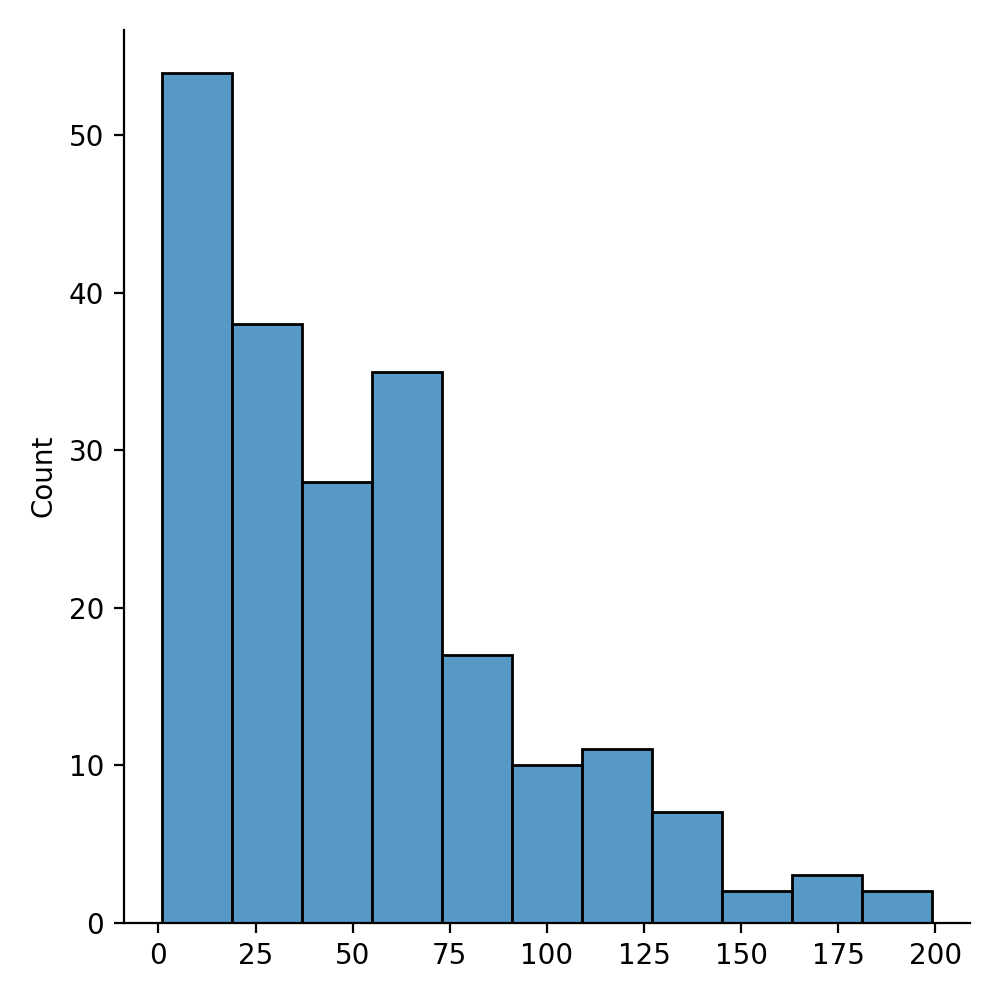

In [23]:
n_domains = []
for cid in df["sbo_client_id"].unique():
    n_domains.append(df.loc[df["sbo_client_id"] == cid]["trimmed_domain"].nunique())
print(f"Min:\t{min(n_domains)}")
print(f"Median:\t{median(n_domains)}")
print(f"Mean:\t{mean(n_domains)}")
print(f"Max:\t{max(n_domains)}")
sns.displot(n_domains)

# When was the data collected?

<IPython.core.display.Javascript object>


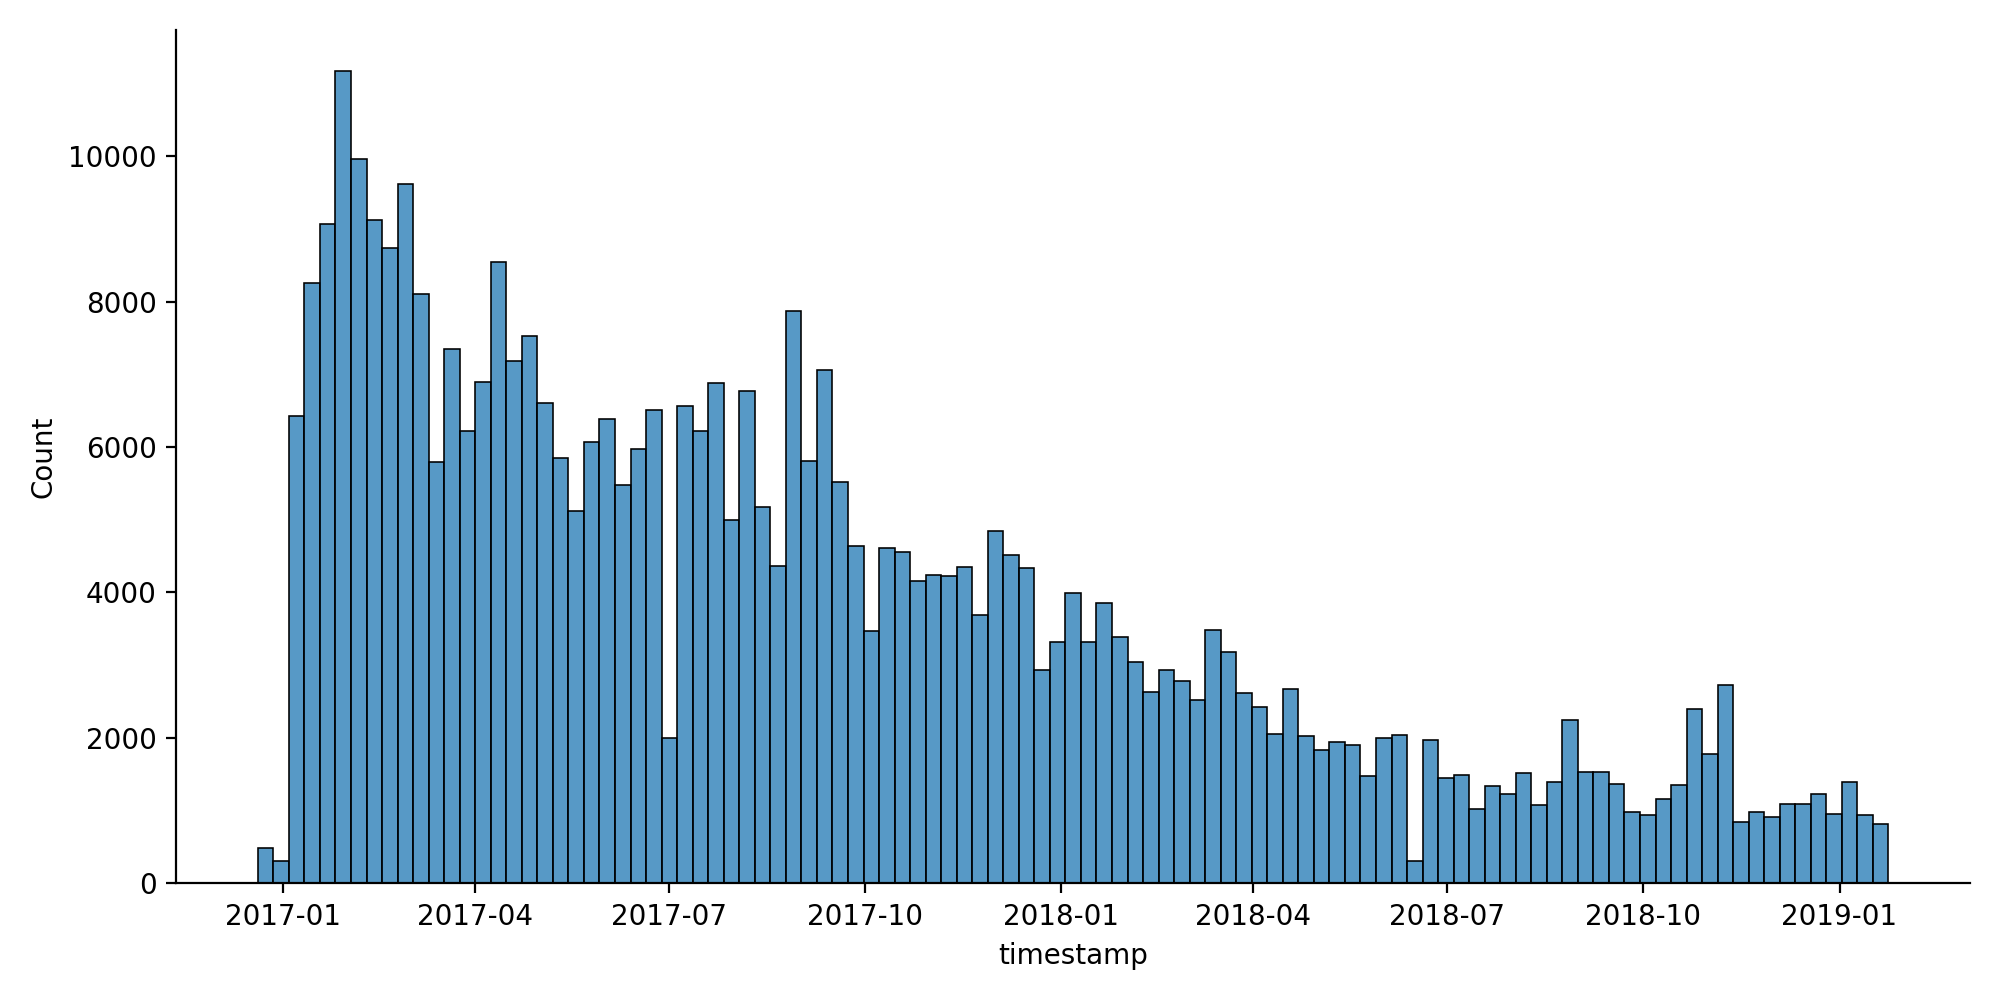

In [24]:
sns.displot(df["timestamp"], height=5, aspect=2)

In [25]:
df["timestamp"].min(), df["timestamp"].max(), df["timestamp"].median()

(Timestamp('2016-12-20 03:05:47'),
 Timestamp('2019-01-23 22:54:58'),
 Timestamp('2017-07-30 06:12:14'))

# Which Domains Were Most Popular?
i.e., which domains were logged into by the greatest number of SBO participants?

In [26]:
d_df.sort_values("n_participants", ascending=False)

,trimmed_domain,n_participants,early_tranco_rank,late_tranco_rank,current_tranco_rank
10,amazon.com,172,5.0,8.0,18.0
2,google.com,155,1.0,1.0,1.0
21,facebook.com,133,3.0,4.0,4.0
25,paypal.com,99,49.0,34.0,78.0
14,sona-systems.com,94,22287.0,28850.0,108260.0
...,...,...,...,...,...
2260,mymortgage-online.com,1,339908.0,248555.0,37381.0
2261,rocketaccount.com,1,64815.0,55905.0,31630.0
2262,getsimpl.com,1,298552.0,235151.0,139599.0
2263,ryanair.com,1,1593.0,1800.0,2429.0


# How does domain popularity compare to Tranco ratings?

In [27]:
# Range of Tranco rankings we saw in our SBO data
print("Time\tMin\tMax")
print(f"Early\t{df['early_tranco_rank'].min()}\t{df['early_tranco_rank'].max()}")
print(f"Late\t{df['late_tranco_rank'].min()}\t{df['late_tranco_rank'].max()}")
print(f"Current\t{df['current_tranco_rank'].min()}\t{df['current_tranco_rank'].max()}")

Time	Min	Max
Early	1.0	7376670.0
Late	1.0	7445256.0
Current	1.0	4811729.0


In [28]:
# Range of rankings in the Tranco data itself, not considering SBO data
print("Time\tMin\tMax")
print(f"Early\t{early_t_df['tranco_rank'].min()}\t{early_t_df['tranco_rank'].max()}")
print(f"Late\t{late_t_df['tranco_rank'].min()}\t{late_t_df['tranco_rank'].max()}")
print(f"Current\t{current_t_df['tranco_rank'].min()}\t{current_t_df['tranco_rank'].max()}")

Time	Min	Max
Early	1	7410679
Late	1	7506162
Current	1	4828057


Comparing the number of participants we saw log into different domains to those domain's Tranco rakings. Useful for identifying sites, like cmu.edu and sona-systems.com, which were study specific.

In [29]:
# Based on: https://stackoverflow.com/a/47166787

def update_annot(attrd, d_df):
    pos = sc.get_offsets()[attrd["ind"][0]]
    annot.xy = pos
    # Multiple indices can be under the cursor at the same time
    domains = []
    for ind in attrd["ind"]:
        domains.append(d_df.iloc[ind].domain)
    annot.set_text("\n".join(domains))
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[attrd["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def onclick(event, d_df):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, attrd = sc.contains(event)
        if cont:
            update_annot(attrd, d_df)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

<IPython.core.display.Javascript object>


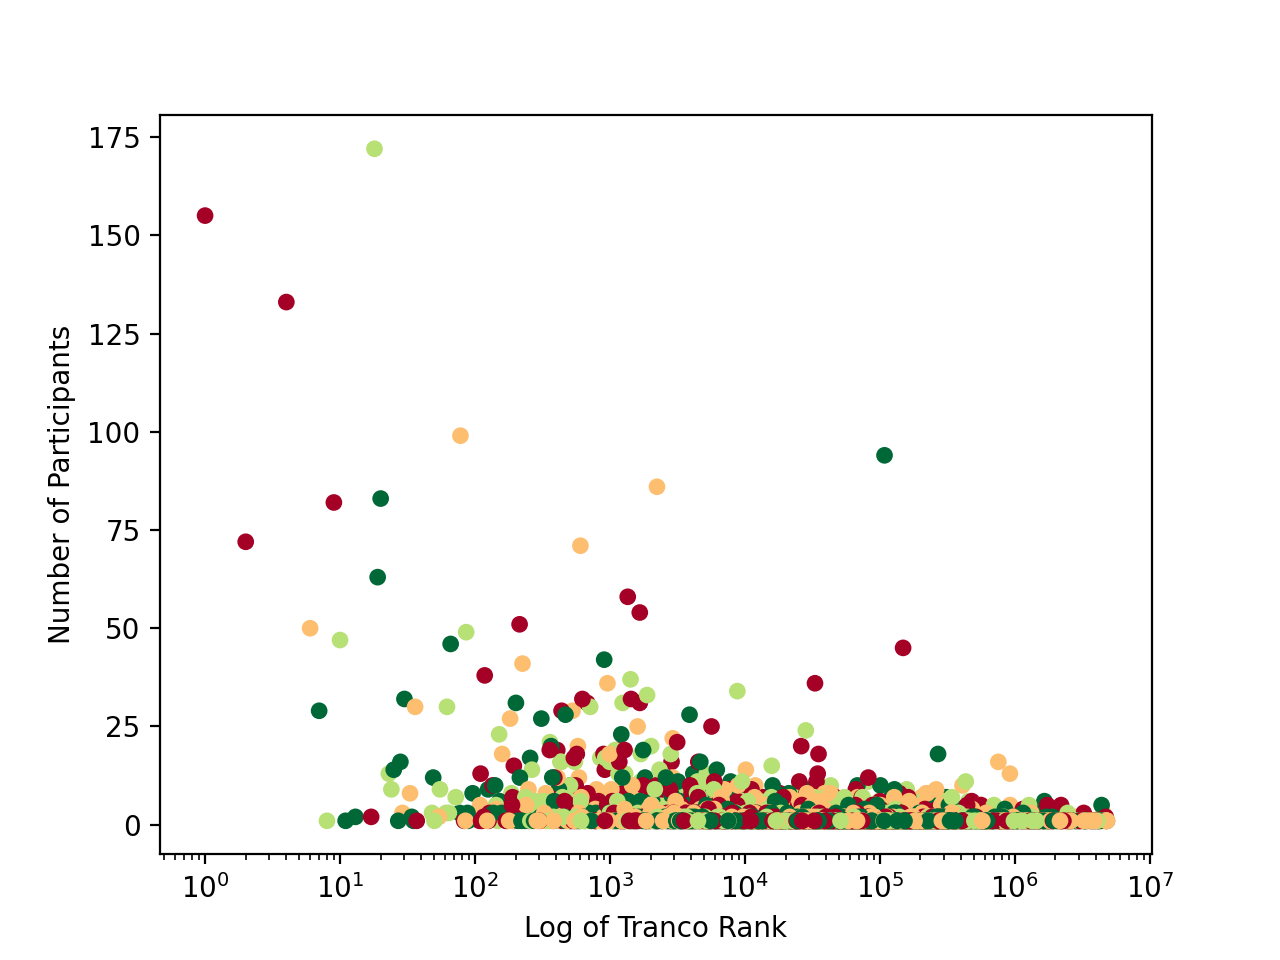

In [30]:
x = d_df["current_tranco_rank"]
y = d_df["n_participants"]
np.random.seed(42)
c = np.random.randint(1,5,size=len(x))

norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
sc = plt.scatter(x,y,c=c, s=25, cmap=cmap, norm=norm)
ax.set_ylabel("Number of Participants")
ax.set_xlabel("Log of Tranco Rank")
ax.set_xscale("log")

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

fig.canvas.mpl_connect("button_press_event", lambda event: onclick(event, d_df))

plt.show()

I think the ECDF plot below could be useful for selecting which websites to test. In the graph, for each domain represented in the SBO data, I count the domain's Tranco rank as many times as unique participants logged into it (i.e., the number of accounts on the domain, assuming each SBO participant only had one account on each domain). Looking at a particular x-axis value shows the proportion of observed accounts with that Tranco rank or lower. For example, looking at x=1 (i.e., the most popular domain according to Tranco) we see that 1.5% of the accounts were on this domain. 

If I’m thinking about it correctly, the graph shows that if you look at the top-1000 most popular websites, this only captures ~30% of the websites people have accounts on. I could use this graph to decide which Tranco rankings to sample from, to gather a representative sample. For example, with three equal sized buckets, I might sample the most popular domains from those with Tranco ratings 1-1000, medium popularity from 1001-25,000, least popular from 25,001-10,000,000. Of course, I would also sample from the original SBO data, and test for differences between the SBO data and the Tranco-derived data. 


In [31]:
# https://seaborn.pydata.org/tutorial/distributions.html#empirical-cumulative-distributions
def graph_proportion_of_accounts_by_rank(d_df, log_scale=True):
    x_early = []
    x_late = []
    x_current = []
    for index, row in d_df.iterrows():
        x_early.extend([row["early_tranco_rank"]] * row["n_participants"])
        x_late.extend([row["late_tranco_rank"]] * row["n_participants"])
        x_current.extend([row["current_tranco_rank"]] * row["n_participants"])
    g = sns.displot(data={"early": x_early,
                          "late": x_late,
                          "current": x_current},
                    kind="ecdf",
                    log_scale=log_scale)
    g.axes.flat[0].set_title("Proportion of Accounts by Tranco Rank")
    g.set_xlabels(("Log of " if log_scale else "") + "Tranco Rank")

<IPython.core.display.Javascript object>


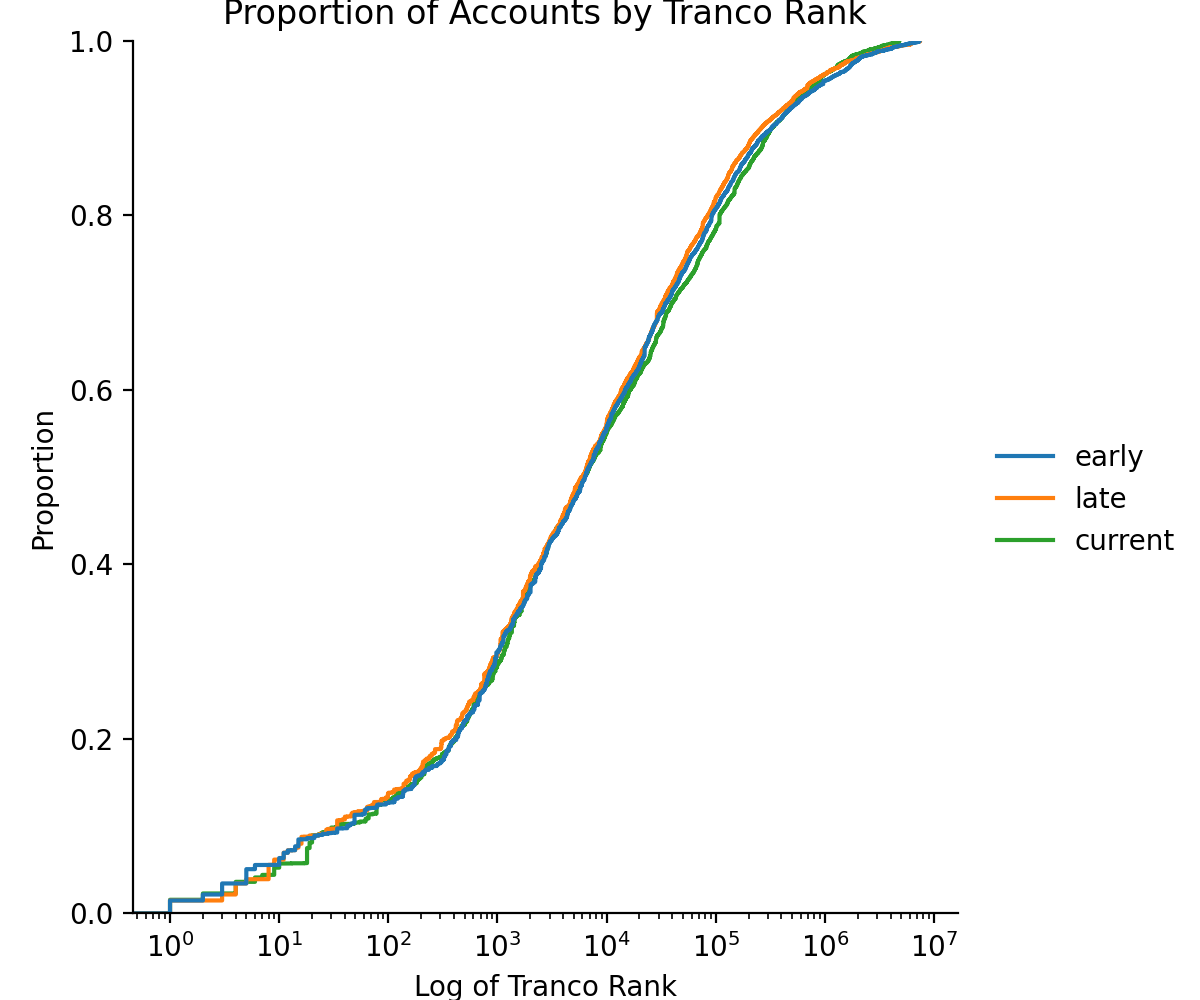

In [32]:
# In these first two ECDF graphs, domains without Tranco ranks are simply omitted
graph_proportion_of_accounts_by_rank(d_df)

<IPython.core.display.Javascript object>


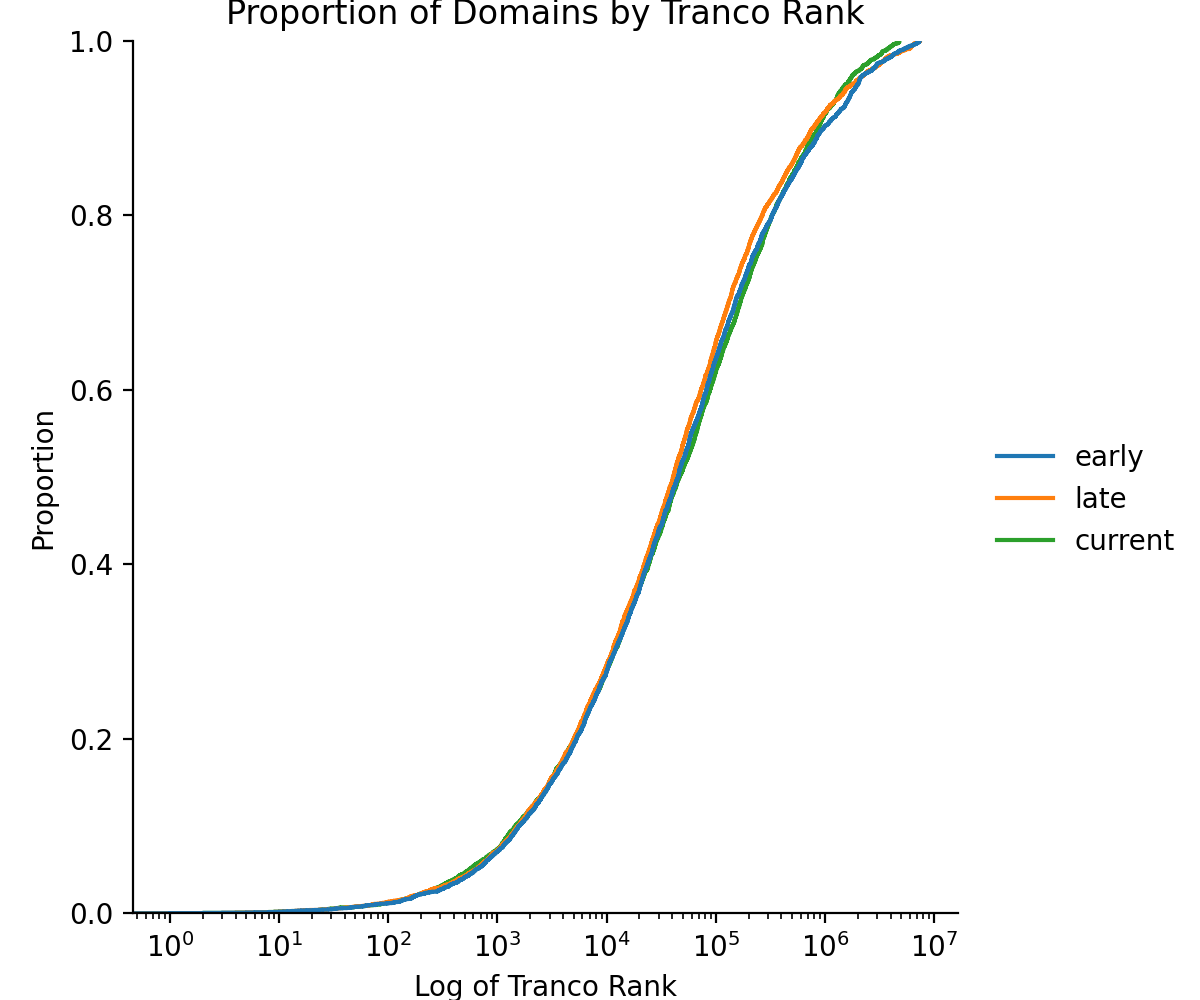

In [33]:
def graph_proportion_of_domains_by_rank(d_df):
    g = sns.displot(data={"early": d_df["early_tranco_rank"],
                          "late": d_df["late_tranco_rank"],
                          "current": d_df["current_tranco_rank"]},
                    kind="ecdf",
                    log_scale=True)
    g.axes.flat[0].set_title("Proportion of Domains by Tranco Rank")
    g.set_xlabels("Log of Tranco Rank")
graph_proportion_of_domains_by_rank(d_df)

In [34]:
# Replace undefined Tranco ranks with the maximum observed Tranco rank + 1
#
# This will allow us to graph the missing domains
def get_filled_df(d_df):
    return d_df.fillna(
        value={"early_tranco_rank": d_df["early_tranco_rank"].max() + 1,
               "late_tranco_rank": d_df["late_tranco_rank"].max() + 1,
               "current_tranco_rank": d_df["current_tranco_rank"].max() + 1})
filled_d_df = get_filled_df(d_df)
filled_d_df

,trimmed_domain,n_participants,early_tranco_rank,late_tranco_rank,current_tranco_rank
0,discover.com,37,374.0,268.0,1420.0
1,zillow.com,17,177.0,156.0,256.0
2,google.com,155,1.0,1.0,1.0
3,ebay.com,49,34.0,27.0,86.0
4,fcbankingonline.com,6,109520.0,95844.0,4811730.0
...,...,...,...,...,...
4338,greenskyonline.com,1,84654.0,57857.0,180741.0
4339,elevacity.com,1,418563.0,464627.0,4811730.0
4340,2020identity.com,1,7376671.0,7209669.0,4811730.0
4341,schwabrt.com,1,167046.0,128268.0,152205.0


<IPython.core.display.Javascript object>


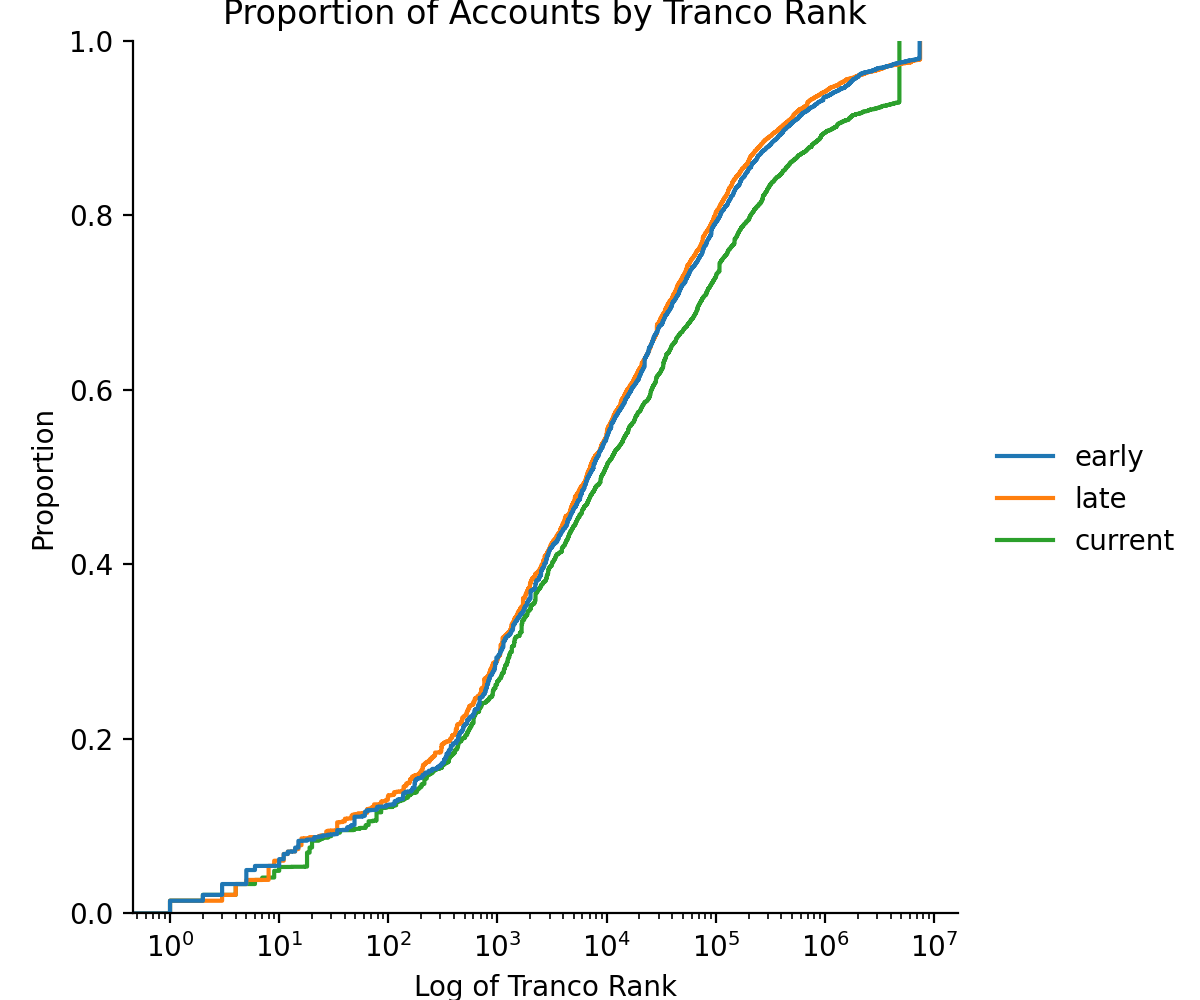

In [35]:
# In these graphs, we include the domains that didn't have Tranco ranks.
# They are shown in the jump at the right of the series.
graph_proportion_of_accounts_by_rank(filled_d_df)

<IPython.core.display.Javascript object>


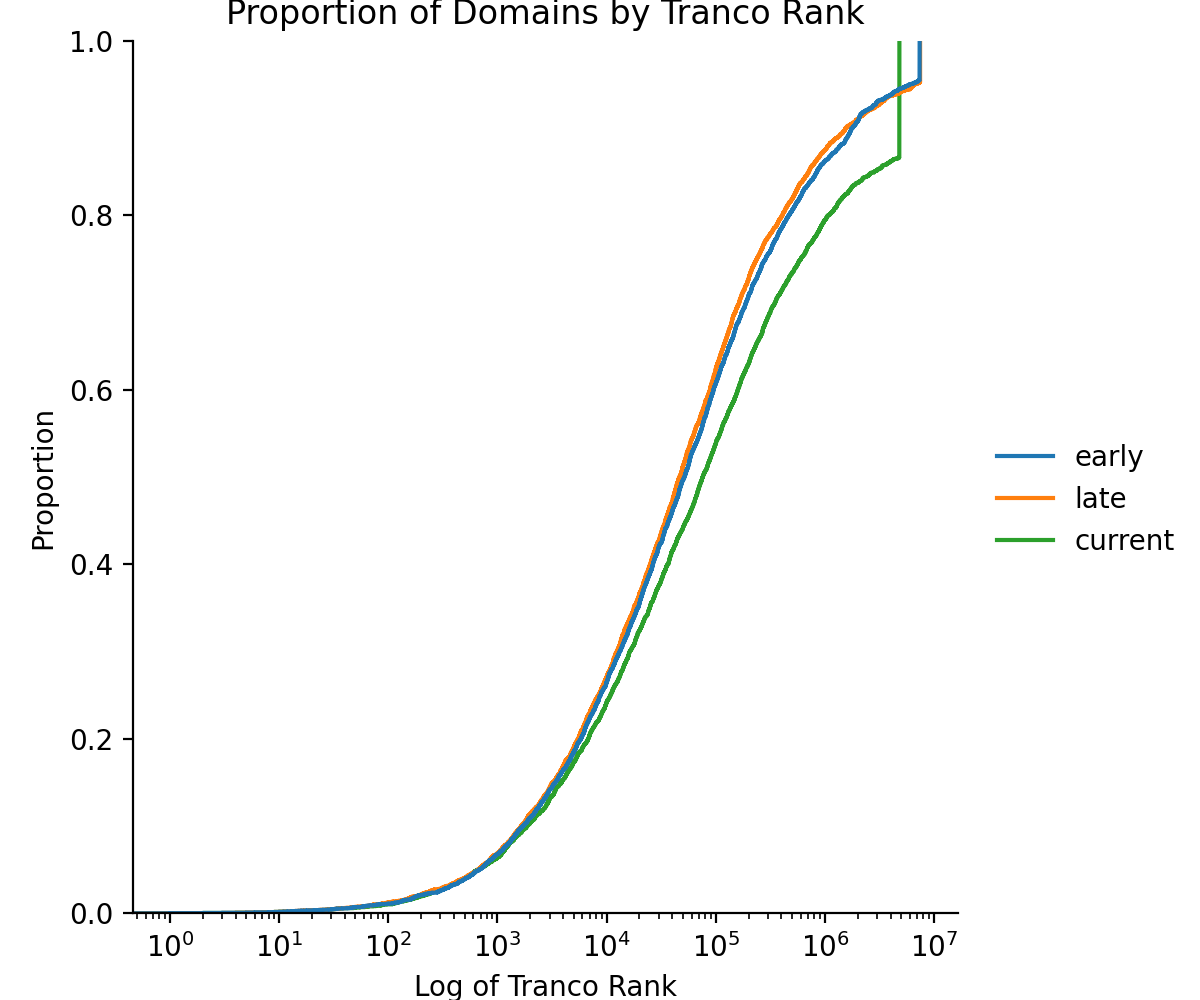

In [36]:
graph_proportion_of_domains_by_rank(filled_d_df)

# Re-analyzing Using the Last Year of Data

In [37]:
# Getting the last year of data
start_date = pd.to_datetime((df["timestamp"].max() - timedelta(days=365)).date())
start_date

Timestamp('2018-01-23 00:00:00')

In [38]:
year_df = df.loc[df["timestamp"] >= start_date]
year_d_df = get_domain_df(year_df)
year_d_df["early_tranco_rank"] = year_d_df.apply(lambda r: get_tranco_rank(r, early_t_df), axis=1)
year_d_df["late_tranco_rank"] = year_d_df.apply(lambda r: get_tranco_rank(r, late_t_df), axis=1)
year_d_df["current_tranco_rank"] = year_d_df.apply(lambda r: get_tranco_rank(r, current_t_df), axis=1)

In [39]:
# How many participants remain?
year_df["sbo_client_id"].nunique()

86

In [40]:
# How many domains remain?
len(year_d_df)

1614

The curve rises a bit more quickly when we only consider the most recent year of data. However, the overall message stays the same.

<IPython.core.display.Javascript object>


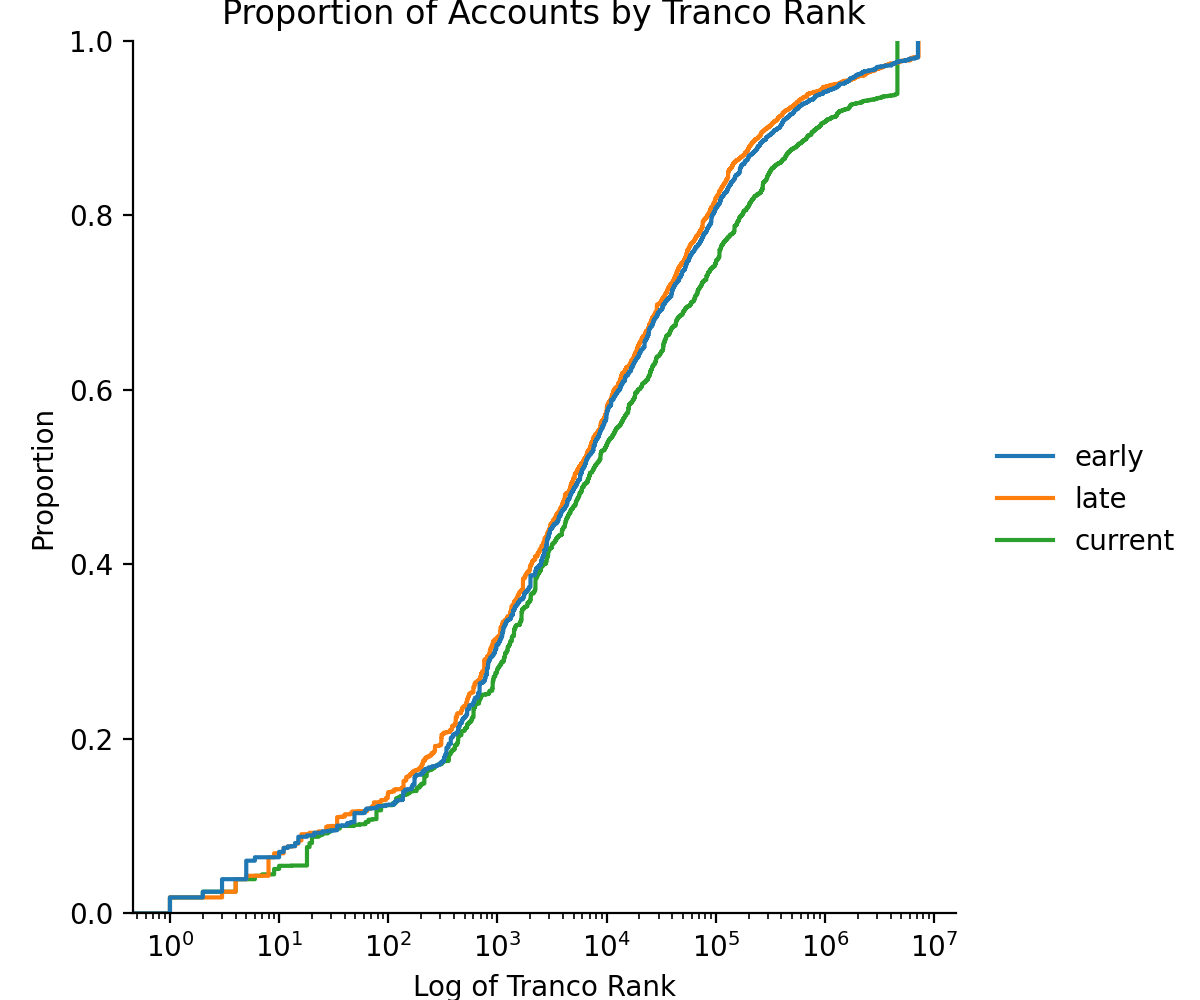

In [41]:
graph_proportion_of_accounts_by_rank(get_filled_df(year_d_df))

# Other things to check
- How much did domain popularity change over time?
- Plot an ECDF of logins
- Test whether my bins make sense, qualitatively (e.g., do I recognize the sites in the first bin, some of them in the second, and none in the third?)

# Do Tranco Percentiles Make Sense?
I should also rerun this on the SBO data.

In [42]:
x_current = []
for index, row in filled_d_df.iterrows():
    x_current.extend([row["current_tranco_rank"]] * row["n_participants"])
# NOTE Not sure if this is > or >=
print("Percentile\tTranco Rank")
for p in [10, 25, 33.33, 50, 66.66, 75, 90]:
    print(f"{p}%\t\t{np.percentile(x_current, p)}")

Percentile	Tranco Rank
10%		62.0
25%		896.0
33.33%		1690.0
50%		8936.0
66.66%		48772.63000000001
75%		114816.0
90%		1194523.0


In [43]:
# Less than 10th-percentile
current_t_df.loc[current_t_df["tranco_rank"] <= 62].sample(10)

,tranco_rank
domain,
microsoftonline.com,28
microsoft.com,5
flickr.com,57
wordpress.org,16
amazonaws.com,29
blogspot.com,43
weibo.com,37
wikipedia.org,11
goo.gl,32


In [44]:
# In the 33.33th-percentile
current_t_df.loc[current_t_df["tranco_rank"] <= 1690].sample(10)

,tranco_rank
domain,
giphy.com,328
js7k.com,1339
evernote.com,355
biblegateway.com,1021
livechatinc.com,1495
aspnetcdn.com,1267
google.be,1171
wayfair.com,607
metro.co.uk,950


In [45]:
# Between 33.33th-percentile and 66.66th-percentile
current_t_df.loc[(current_t_df["tranco_rank"] > 1690) &
                 (current_t_df["tranco_rank"] < 48772.63)].sample(10)

,tranco_rank
domain,
sildenafilsmart.com,39837
udla.edu.ec,15478
ksyun.com,15302
golfgenius.com,43956
superhard.us,20724
toro.com,29708
iif.hu,47109
cual-es-mi-ip.net,44888
mystateline.com,41138


In [46]:
# Above 66.66th-percentile
current_t_df.loc[current_t_df["tranco_rank"] > 48772.63].sample(10)

,tranco_rank
domain,
vykupauto77.ru,4133791
retailerreportcard.com,4806529
bekamedikal.com,3433778
cbxstudio.com,2932641
rmx.news,195967
uniformnext.com,612695
sellingrevolution.com,1505261
wifegardennot.top,4511009
buywinespirits.com,3762064


# Weighted Random Sampling

In [47]:
d_df_sample = filled_d_df.sample(frac=1.0,
                                 weights="n_participants",
                                 random_state=22)
SAMPLE_SIZE = 100
d_df_sample[:SAMPLE_SIZE]

,trimmed_domain,n_participants,early_tranco_rank,late_tranco_rank,current_tranco_rank
148,swagbucks.com,16,2788.0,2217.0,2860.0
762,23andme.com,4,4012.0,2643.0,6902.0
566,nyu.edu,1,748.0,832.0,722.0
2973,malakye.com,1,209631.0,215449.0,232004.0
93,reddit.com,30,21.0,14.0,36.0
...,...,...,...,...,...
1269,neopets.com,6,8518.0,8675.0,22025.0
2739,adpserviceedge.com,1,266701.0,207344.0,827384.0
6,duquesnelight.com,45,91108.0,75872.0,148604.0
1823,universitytickets.com,2,53750.0,50886.0,37792.0


<IPython.core.display.Javascript object>


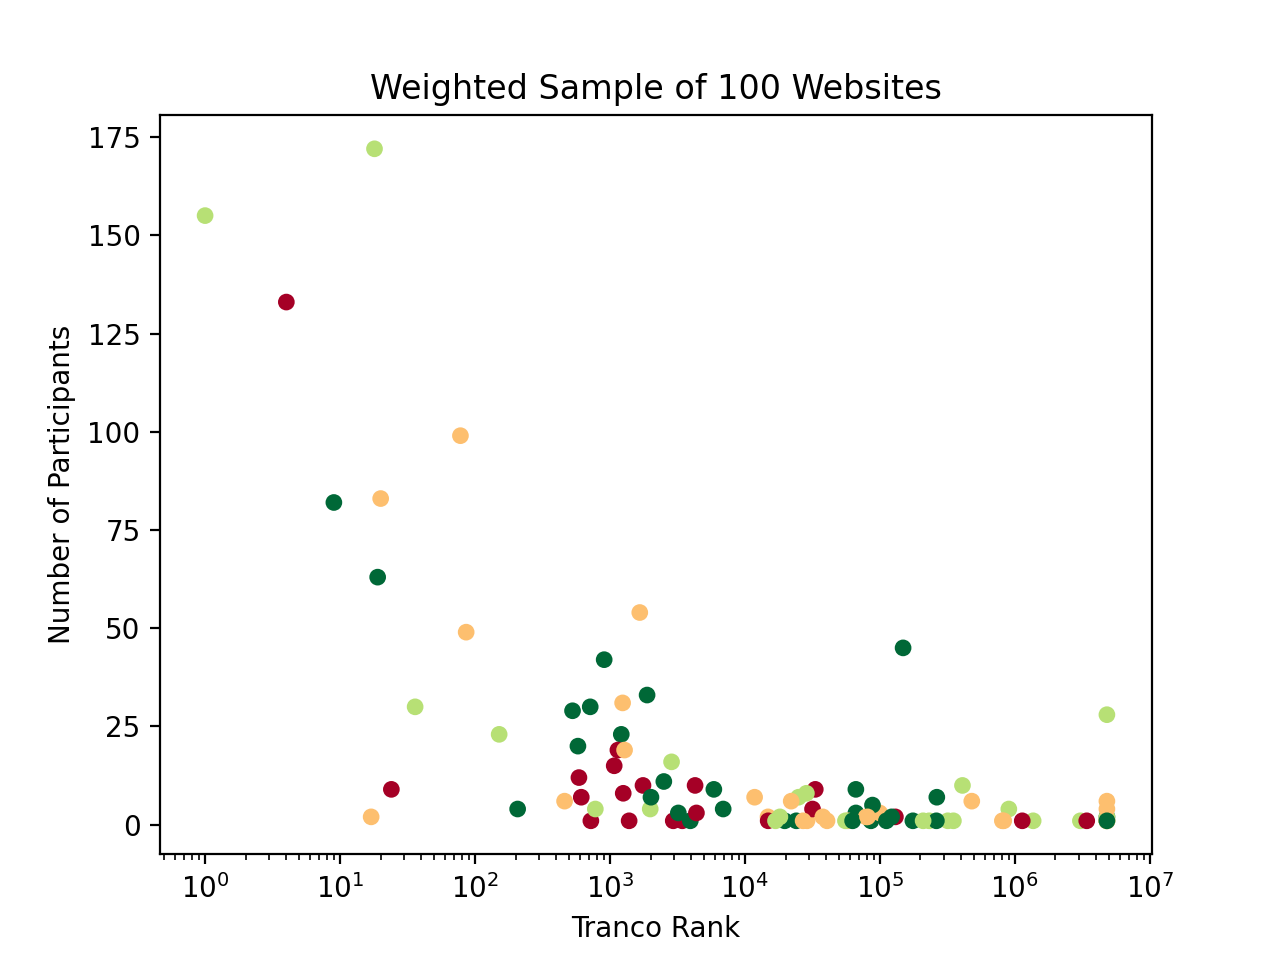

In [48]:
x = d_df_sample["current_tranco_rank"][:SAMPLE_SIZE]
y = d_df_sample["n_participants"][:SAMPLE_SIZE]
np.random.seed(42)
c = np.random.randint(1,5,size=len(x))

norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
sc = plt.scatter(x, y, c=c, s=25, cmap=cmap, norm=norm)
ax.set_title(f"Weighted Sample of {SAMPLE_SIZE} Websites")
ax.set_ylabel("Number of Participants")
ax.set_xlabel("Tranco Rank")
ax.set_xscale("log")

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

fig.canvas.mpl_connect("button_press_event", lambda event: onclick(event, d_df_sample))

plt.show()

<IPython.core.display.Javascript object>


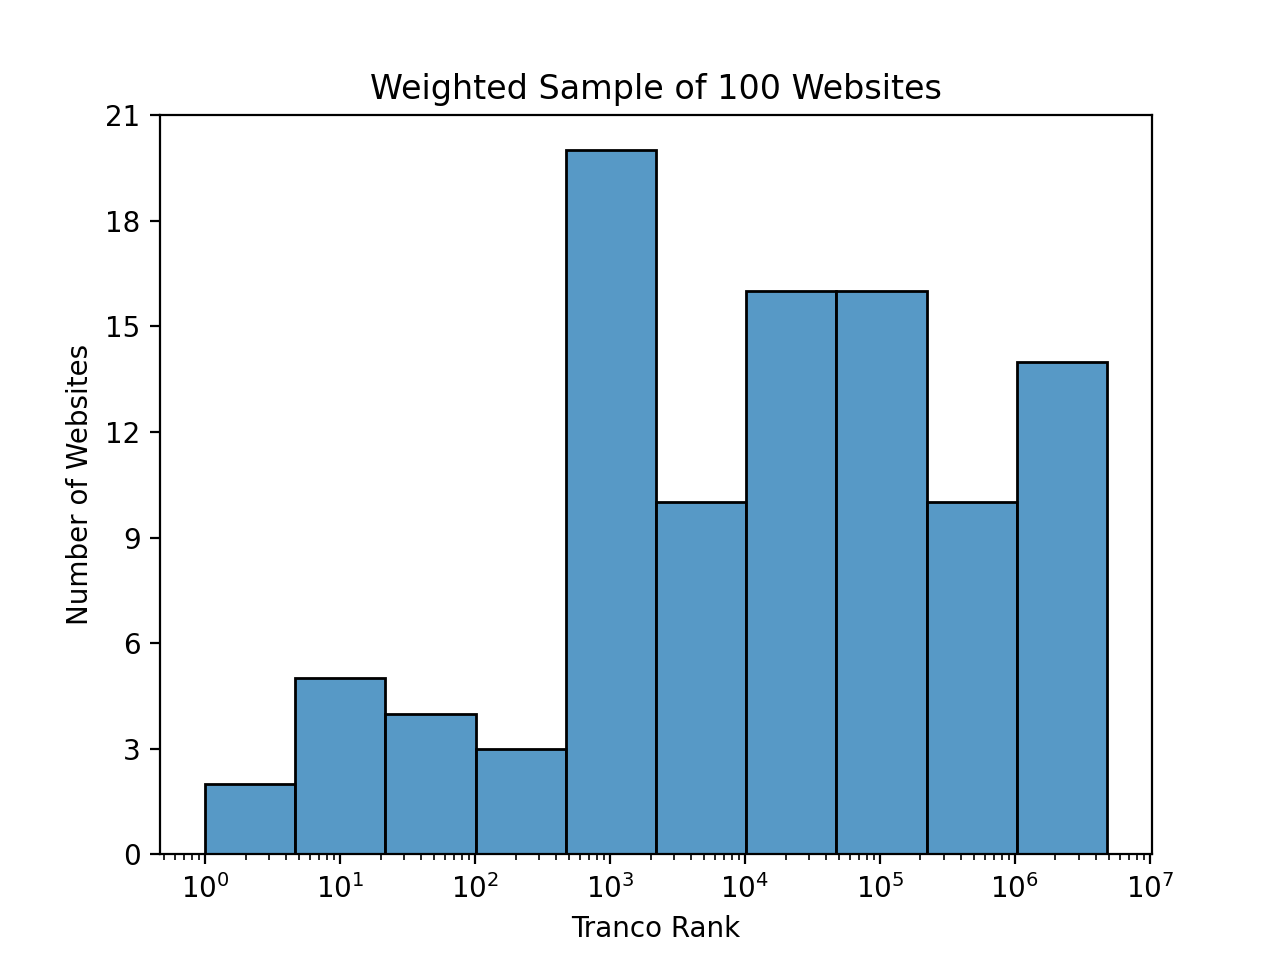

In [49]:
fig,ax = plt.subplots()
ax.set_ylabel("Number of Websites")
ax.set_xlabel("Tranco Rank")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

sns.histplot(d_df_sample[:SAMPLE_SIZE]["current_tranco_rank"],
             bins=10,
             log_scale=True).set(title=f"Weighted Sample of {SAMPLE_SIZE} Websites")
plt.show()